In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
import re
import py_vncorenlp
import os
# from langdetect import detect

# py_vncorenlp.download_model(os.environ["VNCORENLP"])
pd.options.display.max_columns = None

cwd = os.getcwd()
annotator = py_vncorenlp.VnCoreNLP(save_dir=os.environ["VNCORENLP"])
os.chdir(cwd)

ASPECT_REGEX = re.compile(r"{([\w&]+)(?:#(\w+))?}")

with open("./stopwords.txt", "r") as f:
    stopwords = [line.replace(" ", "_").strip() for line in f.readlines()]

2024-04-27 12:05:32 INFO  WordSegmenter:24 - Loading Word Segmentation model
2024-04-27 12:05:32 INFO  PosTagger:23 - Loading POS Tagging model
2024-04-27 12:05:34 INFO  NerRecognizer:34 - Loading NER model
2024-04-27 12:05:41 INFO  DependencyParser:32 - Loading Dependency Parsing model


In [2]:
visfd = pd.read_csv("/home/ptdat/Desktop/ViSFD/data/Train.csv").set_index("index")
visfd.head()

,comment,n_star,date_time,label
index,,,,
0,Mới mua máy này Tại thegioididong thốt nốt cảm...,5,2 tuần trước,{CAMERA#Positive};{FEATURES#Positive};{BATTERY...
1,Pin kém còn lại miễn chê mua 8/3/2019 tình trạ...,5,14/09/2019,{BATTERY#Negative};{GENERAL#Positive};{OTHERS};
2,Sao lúc gọi điện thoại màn hình bị chấm nhỏ nh...,3,17/08/2020,{FEATURES#Negative};
3,"Mọi người cập nhật phần mềm lại , nó sẽ bớt tố...",3,29/02/2020,{FEATURES#Negative};{BATTERY#Neutral};{GENERAL...
4,"Mới mua Sài được 1 tháng thấy pin rất trâu, Sà...",5,4/6/2020,{BATTERY#Positive};{PERFORMANCE#Positive};{SER...


In [3]:
visfd["segmented"] = visfd.comment.map(
    lambda s: " ".join(annotator.word_segment(s))
)
visfd["label_as_dict"] = [
    dict(ASPECT_REGEX.findall(label))
    for label in visfd.label.values
]
# visfd["lang"] = [
#     detect(c)
#     for c in visfd.comment.values
# ]

(-0.5, 499.5, 499.5, -0.5)

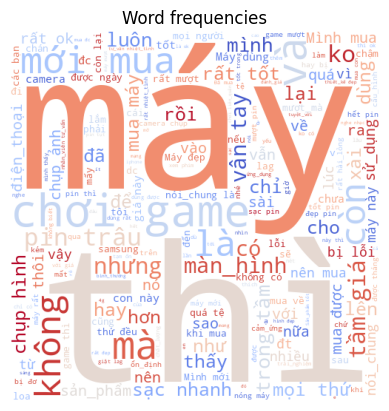

In [4]:
wc_size = 500
wc = wordcloud.WordCloud(
    width=wc_size,
    height=wc_size,
    # stopwords=stopwords,
    colormap="coolwarm",
    background_color="white",
    min_word_length=1
)
img = wc.generate(" ".join(visfd.segmented))
plt.imshow(img)
plt.title("Word frequencies")
plt.axis("off")

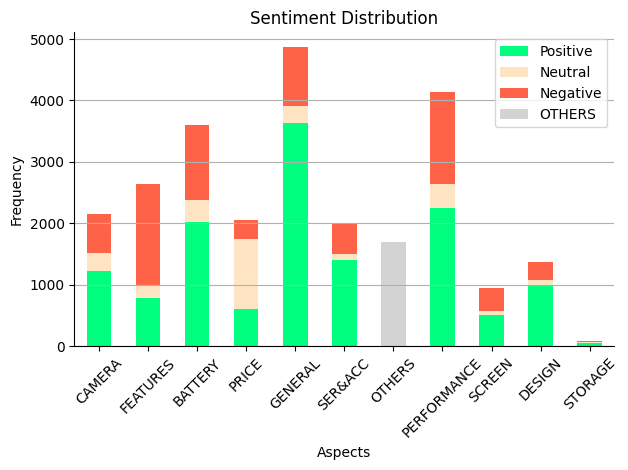

In [5]:
a_p_counts = {}
for label in visfd.label_as_dict:
    for a, p in label.items():
        if a not in a_p_counts:
            a_p_counts[a] = {}
        if p not in a_p_counts[a]:
            a_p_counts[a][p] = 0
        a_p_counts[a][p] += 1

a_p_df = pd.DataFrame(a_p_counts).T
a_p_df.rename(columns={"": "OTHERS"}, inplace=True)

colors = ['springgreen', 'bisque', 'tomato', "lightgray"]  # Positive, Neutral, Negative, OTHERS
a_p_df.plot(kind='bar', stacked=True, color=colors)

plt.xlabel('Aspects')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution')

plt.xticks(rotation=45)
sns.despine()
plt.grid(axis="y")
plt.tight_layout()

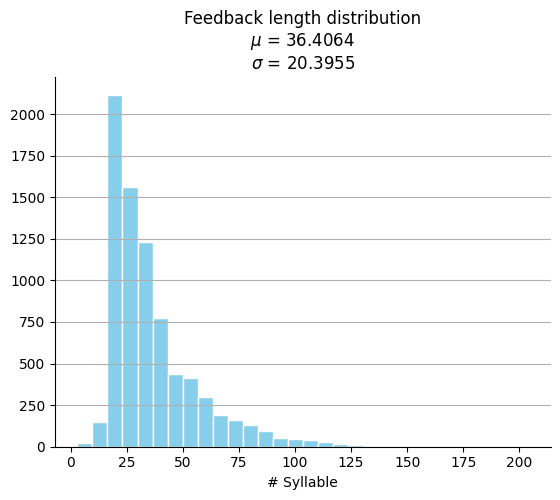

In [6]:
n_syllable = visfd.comment.str.split(" ").map(lambda x: len(x)) 
plt.hist(
    n_syllable,
    edgecolor="white",
    color="skyblue",
    bins=30
)
plt.title(f"Feedback length distribution\n$\\mu$ = {np.mean(n_syllable):.4f}\n$\\sigma$ = {np.std(n_syllable):.4f}")
plt.xlabel("# Syllable")
sns.despine()
plt.grid(axis="y")

/home/ptdat/Desktop/venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 62541 (\uf44d) missing from current font.
  func(*args, **kwargs)
/home/ptdat/Desktop/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 62541 (\uf44d) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


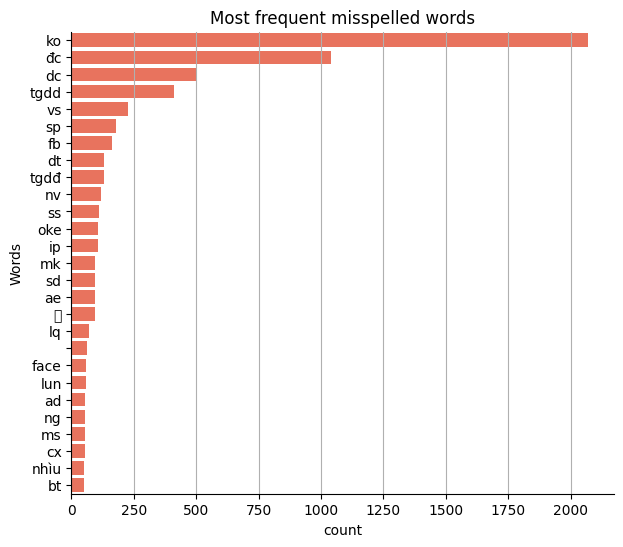

In [37]:
with open("misspelling.txt", "r") as f:
    misspelled = pd.Series([
        line
        for line in f.read().splitlines()
        if line != ""
    ])

# k = 30
min_freq = 50
orders = misspelled.value_counts()[misspelled.value_counts() > min_freq].index

plt.figure(figsize=(7, 6))
sns.countplot(misspelled, color="tomato", order=orders).set(
    title=f"Most frequent misspelled words",
    ylabel="Words"
)
sns.despine()
plt.grid(axis="x")

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from typing import Sequence

def top_tfidf_ranking(
    corpus: Sequence[str], 
    stopwords: Sequence[str] = None, 
    k: int = 5
):
    tfidf_vect = TfidfVectorizer(stop_words=stopwords).fit(corpus)

    tfidf = tfidf_vect.transform(corpus).mean(axis=0)
    tfidf = np.asarray(tfidf).ravel()
    top_k = tfidf.argsort()[-k:]

    top_k_terms = tfidf_vect.get_feature_names_out()[top_k]
    top_k_tfidf = tfidf[top_k]
    return {
        t: v
        for t, v in zip(top_k_terms, top_k_tfidf)
    }

def query(
    visfd: pd.DataFrame, 
    a: str = None,
    p: str = None
):
    if a is None and p is None:
        return visfd
    
    def match(d: dict[str, str]):
        match_a = a in d.keys() if a is not None else True
        match_p = True if p is None \
                    else p in d.values() if a is None \
                    else False if a not in d.keys() \
                    else d[a] == p
        return match_a and match_p
    
    matched = visfd.label_as_dict.map(match)
    return visfd[matched]

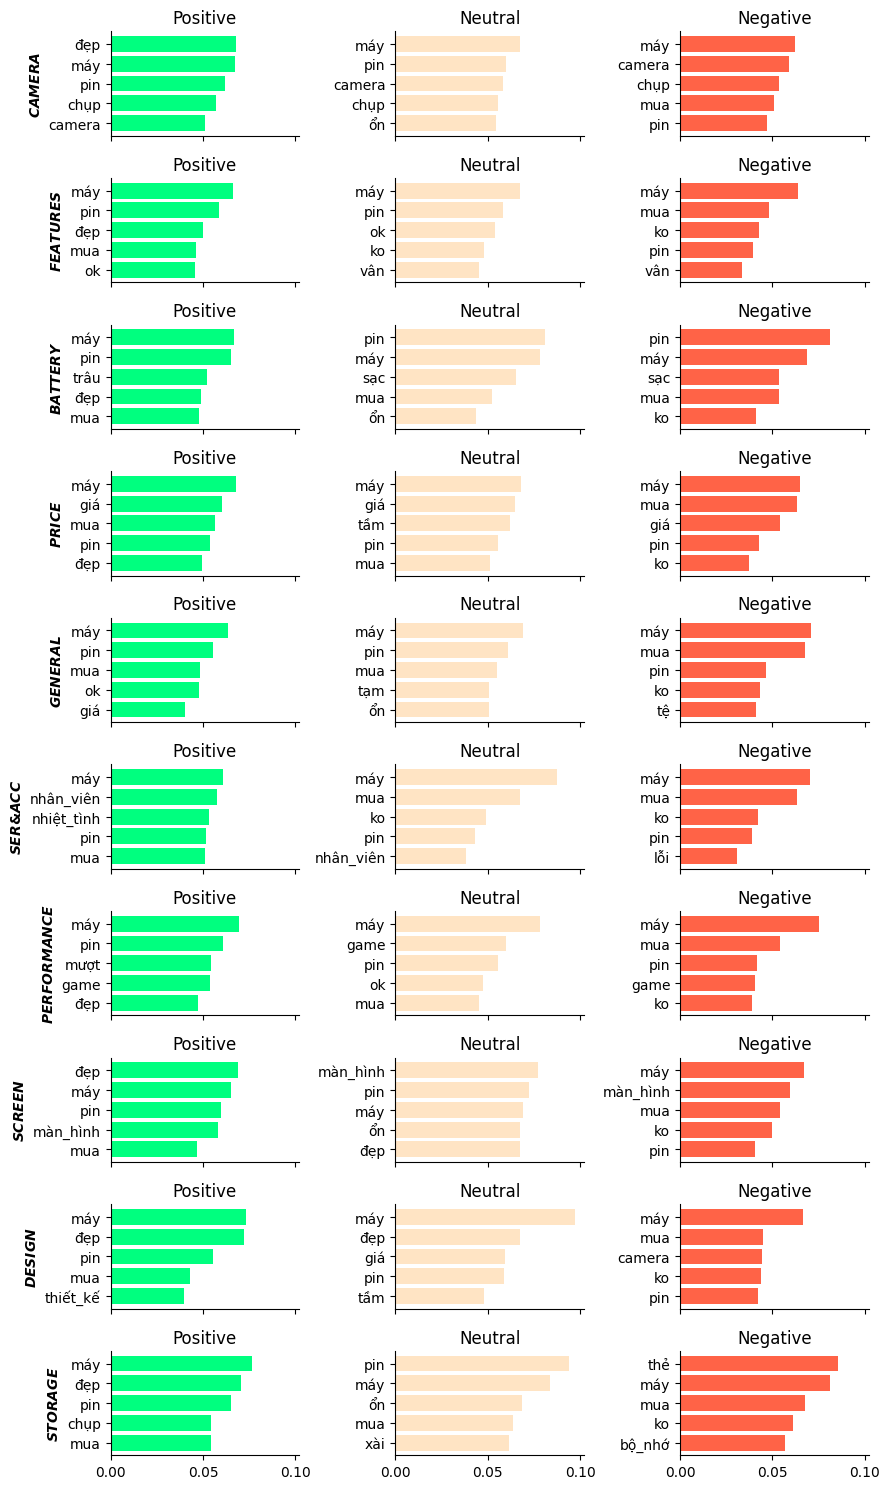

In [10]:
A = ["CAMERA", "FEATURES", "BATTERY", "PRICE", "GENERAL", "SER&ACC", "PERFORMANCE", "SCREEN", "DESIGN", "STORAGE"]
P = ["Positive", "Neutral", "Negative"]

subplot_w = 3
subplot_h = 1.5
fig, ax = plt.subplots(
    len(A), len(P), 
    sharex=True,
    figsize=(len(P)*subplot_w, len(A)*subplot_h)
)

for a_i, a in enumerate(A):
    for p_i, (p, c) in enumerate(zip(P, colors)):
        ap_tfidf = top_tfidf_ranking(
            query(visfd, a, p).segmented,
            stopwords=stopwords
        )
        ys = list(ap_tfidf.keys())
        xs = list(ap_tfidf.values())
        ax[a_i, p_i].barh(ys, xs, color=c)
        ax[a_i, p_i].set_title(p)
        if p_i == 0:
            ax[a_i, p_i].set_ylabel(r"$\boldsymbol{" + a + "}$")
fig.tight_layout()
sns.despine()